# Preparation

In [1]:
import os
import sys

import pandas as pd

pd.set_option("mode.copy_on_write", True)

script_dir = os.path.abspath("")
mymodule_dir = os.path.join(script_dir, "..", "scripts")
sys.path.append(mymodule_dir)
import cleaning

jobs = cleaning.prep(
    pd.read_pickle("../data/jobs.pkl"), filtered=False, categories_reduced=False
)
# jobs.head()

In [2]:
jobs = jobs[
    (jobs["Description"] != "Nicht stepstone")
    & (jobs["Description"] != "Stellenanzeige nicht mehr verfügbar")
    & (jobs["Description"] != "")
]
texts = jobs["Description"]

In [3]:
import pickle
import re

import nltk
from HanTa import HanoverTagger as ht
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Preprocessing

In [4]:
def tokenize_doc(doc):
    stopwords_ger = stopwords.words("german")
    stopwords_ger.extend(["du", "sie"])
    stopwords_en = stopwords.words("english")

    cleaned = re.sub(
        r"[\W](?=\w)",
        " ",
        doc.replace("\u200b", " ")
        .replace("\xad", "")
        .replace("-", " ")
        .replace("/", " ")
        .replace("·", " ")
        .replace("•", " ")
        .replace("…", " "),
    )
    tokenized = word_tokenize(cleaned, language="german")
    alphas = [w.lower() for w in tokenized if w.isalpha()]

    tagger = ht.HanoverTagger("morphmodel_ger.pgz")

    no_stops_de = [w for w in alphas if w not in stopwords_ger]
    no_stops_de_en = [w for w in no_stops_de if w not in stopwords_en]

    lemmatized = [tagger.analyze(token)[0].lower() for token in no_stops_de_en]

    return lemmatized

In [5]:
if os.path.isfile("../data/lemmatized_desc.pkl"):
    with open("../data/lemmatized_desc.pkl", "rb") as file:
        old_lemmas = pickle.load(file)
else:
    old_lemmas = []

lemmas = old_lemmas

docs = [doc for doc in texts]

In [6]:
if len(docs) > len(old_lemmas):
    new_docs = docs[len(old_lemmas) :]
    docs_count = len(new_docs)
    new_lemmas = []
    print(f"Tokenizing {docs_count} documents")
    i = 1
    for doc in new_docs:
        if i % 500 == 0:
            print(f"{i}/{docs_count}")
        new_lemmas.append(tokenize_doc(doc))
        i += 1
    lemmas += new_lemmas

    with open("../data/lemmatized_docs.pkl", "wb") as file:
        pickle.dump(lemmas, file)

Tokenizing 15796 documents
500/15796
1000/15796
1500/15796
2000/15796
2500/15796
3000/15796
3500/15796
4000/15796
4500/15796
5000/15796
5500/15796
6000/15796
6500/15796
7000/15796
7500/15796
8000/15796
8500/15796
9000/15796
9500/15796
10000/15796
10500/15796
11000/15796
11500/15796
12000/15796
12500/15796
13000/15796
13500/15796
14000/15796
14500/15796
15000/15796
15500/15796


In [7]:
from collections import Counter

all_in_one = [w for doc in lemmas for w in doc]
bow = Counter(all_in_one)
bow.most_common(10)

[('team', 11034),
 ('data', 10554),
 ('sowie', 10286),
 ('management', 5433),
 ('projekt', 5410),
 ('unser', 5198),
 ('business', 5159),
 ('neu', 4983),
 ('kunde', 4961),
 ('unterstützen', 4776)]

In [8]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

dictionary = Dictionary(lemmas)
bow_corpus = [dictionary.doc2bow(doc) for doc in lemmas]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

# BOW

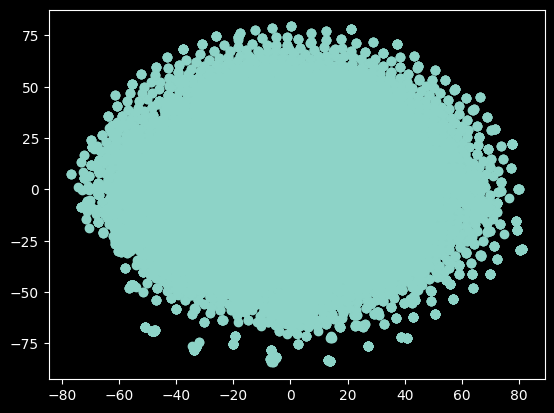

In [9]:
import matplotlib.pyplot as plt
from gensim import matutils
from sklearn.manifold import TSNE

sklearn_vectors = matutils.corpus2csc(bow_corpus).T

model = TSNE(n_components=2, random_state=0, init="random")
transformed = model.fit_transform(sklearn_vectors)
xs = transformed[:, 0]
ys = transformed[:, 1]

plt.scatter(xs, ys)
plt.show()

In [10]:
import pyLDAvis
import pyLDAvis.gensim
from gensim.models.ldamulticore import LdaMulticore

lda_model = LdaMulticore(
    corpus=bow_corpus,
    workers=2,
    id2word=dictionary,
    num_topics=5,
    random_state=100,
    chunksize=50,
    passes=10,
    per_word_topics=True,
)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.256038 -0.030214       1        1  39.848364
2     -0.278734  0.054754       2        1  27.332615
0      0.150344 -0.304427       3        1  25.519957
4      0.202553  0.115620       4        1   4.864490
1      0.181874  0.164266       5        1   2.434574, topic_info=                Term          Freq         Total Category  logprob  loglift
11              data   9050.000000   9050.000000  Default  30.0000  30.0000
578              sap   1906.000000   1906.000000  Default  29.0000  29.0000
45             sowie  10490.000000  10490.000000  Default  28.0000  28.0000
130         supporen   2615.000000   2615.000000  Default  27.0000  27.0000
131           system   3084.000000   3084.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
2320         templat     66.543130    163.970886   Topic5  -5.9816   2.8136
1564               m     73.428075    309.679193   Topic5  -5.8832   2.2762
1881      enterprise     68.000994    229.023597   Topic5  -5.9600   2.5011
3151           chang     75.551098    717.089014   Topic5  -5.8547   1.4650
2109  administration     69.489204    357.754141   Topic5  -5.9383   2.0767

[337 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
232       2  0.998127   abgeschlossen
234       2  0.994493       abschluss
7704      2  0.998067      abwicklung
5210      5  0.986368     acceptancen
1860      3  0.998883           acros
...     ...       ...             ...
564       2  0.108720        zusammen
56        1  0.761933  zusammenarbeit
56        2  0.237694  zusammenarbeit
452       1  0.589856      übernehmen
452       2  0.409905      übernehmen

[497 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])

In [11]:
def calc_topic_for_doc(doc):
    values = []
    tuples = lda_model.get_document_topics(doc)
    for tuple in tuples:
        values.append(tuple[1])
    max_prob = max(values)
    topic = tuples[values.index(max_prob)][0]
    return topic + 1

In [12]:
bow_topic_list = []
for doc in bow_corpus:
    bow_topic_list.append(calc_topic_for_doc(doc))

df_bow = pd.DataFrame(
    {"topics": bow_topic_list, "Job_Kategorie": jobs["Job Kategorie"]}, index=jobs.index
)

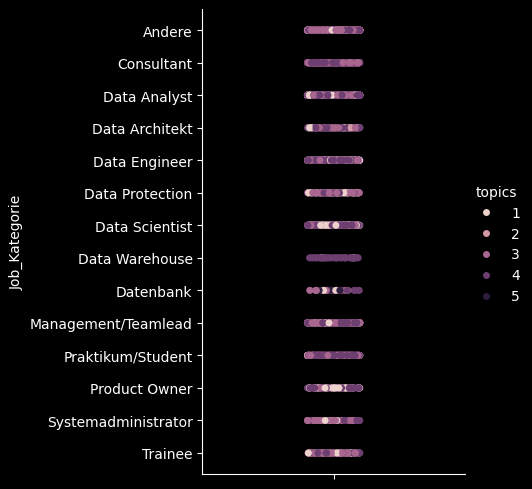

In [13]:
import seaborn as sns

sns.catplot(data=df_bow, hue="topics", y="Job_Kategorie")

# TF-IDF

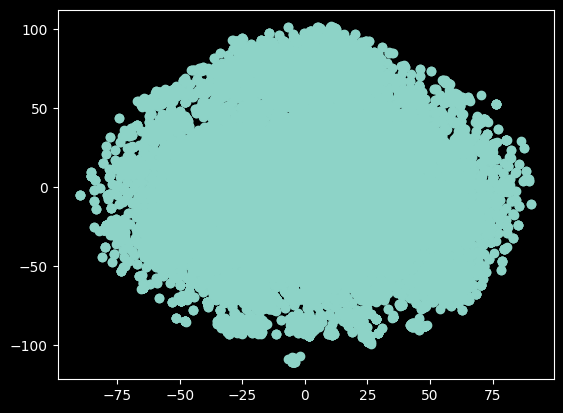

In [14]:
sklearn_vectors = matutils.corpus2csc(tfidf_corpus).T

model = TSNE(n_components=2, random_state=0, init="random")
transformed = model.fit_transform(sklearn_vectors)
xs = transformed[:, 0]
ys = transformed[:, 1]

plt.scatter(xs, ys)
plt.show()

In [15]:
lda_model = LdaMulticore(
    corpus=tfidf_corpus,
    workers=2,
    id2word=dictionary,
    num_topics=3,
    random_state=100,
    chunksize=50,
    passes=10,
    per_word_topics=True,
)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, tfidf_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.155963 -0.004376       1        1  71.696317
1     -0.088256 -0.047630       2        1  22.164389
0     -0.067707  0.052006       3        1   6.139294, topic_info=                                 Term        Freq       Total Category  \
11                               data  142.000000  142.000000  Default   
758                           project   44.000000   44.000000  Default   
770                       development   42.000000   42.000000  Default   
45                              sowie  177.000000  177.000000  Default   
10                           business  100.000000  100.000000  Default   
...                               ...         ...         ...      ...   
64970                   vertriebsnetz    0.740531    2.007212   Topic3   
64971      vertriebspartnernallgemein    0.740531    2.007212   Topic3   
64852  managementneukundenakquisition    0.770774    2.681721   Topic3   
64853          markenproduktefachlich    0.770774    2.681721   Topic3   
64854           verkaufsgebietverkauf    0.770774    2.681721   Topic3   

       logprob  loglift  
11     30.0000  30.0000  
758    29.0000  29.0000  
770    28.0000  28.0000  
45     27.0000  27.0000  
10     26.0000  26.0000  
...        ...      ...  
64970  -9.0194   1.7933  
64971  -9.0194   1.7933  
64852  -8.9794   1.5436  
64853  -8.9794   1.5436  
64854  -8.9794   1.5436  

[170 rows x 6 columns], token_table=       Topic      Freq                             Term
term                                                   
38447      3  0.970746  absicherungsstrategiedefinition
13183      3  0.987216                 absicherungstest
1860       2  0.987572                            acros
136        1  0.971785                          analyse
136        2  0.023702                          analyse
...      ...       ...                              ...
741        2  0.955428                             work
762        2  0.974216                          working
55         1  0.994738                                z
56         1  0.998126                   zusammenarbeit
452        1  0.995751                       übernehmen

[175 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [16]:
tfidf_topic_list = []
for doc in tfidf_corpus:
    tfidf_topic_list.append(calc_topic_for_doc(doc))

df_tfidf = pd.DataFrame(
    {"topics": tfidf_topic_list, "Job_Kategorie": jobs["Job Kategorie"]},
    index=jobs.index,
)

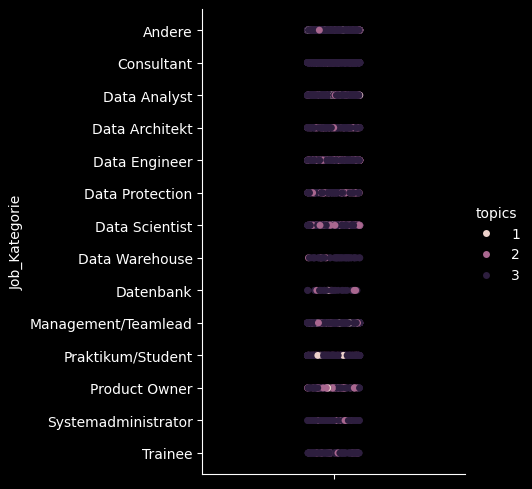

In [17]:
sns.catplot(data=df_tfidf, hue="topics", y="Job_Kategorie")